<a href="https://colab.research.google.com/github/dsogden/Quantitative_Finance/blob/main/MRT_Medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
stock_symbols = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'BRK-A', 'NVDA',
    'JPM', 'JNJ', 'V', 'PG', 'UNH', 'MA', 'DIS', 'HD', 'BAC', 'VZ',
    'INTC', 'KO', 'PFE', 'WMT', 'MRK', 'PEP', 'T', 'BA', 'XOM', 'ABBV',
    'NKE', 'MCD', 'CSCO', 'DOW', 'ADBE', 'IBM', 'CVX', 'CRM', 'ABT', 'MDT',
    'PYPL', 'NEE', 'COST', 'AMGN', 'CMCSA', 'NFLX', 'ORCL', 'PM', 'HON', 'ACN',
    'TMO', 'AVGO'
]

df = {}
for symbol in stock_symbols:
    data = yf.download(symbol, start='2015-01-01', end='2023-01-1')
    df[symbol] = data['Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [3]:
df['AAPL']

Date
2015-01-02     27.332500
2015-01-05     26.562500
2015-01-06     26.565001
2015-01-07     26.937500
2015-01-08     27.972500
                 ...    
2022-12-23    131.860001
2022-12-27    130.029999
2022-12-28    126.040001
2022-12-29    129.610001
2022-12-30    129.929993
Name: Close, Length: 2014, dtype: float64

In [5]:
stationary_stocks = []

for symbol, data in df.items():
    outputs = adfuller(data.values)
    pvalue = outputs[1]
    if pvalue < 0.05:
        stationary_stocks.append([symbol, pvalue])
print(len(stationary_stocks))

1


In [6]:
stationary_stocks

[['IBM', 0.01250999570324941]]

In [18]:
def plot_stocks(data: list, df: dict) -> None:
    for stock, pvalue in data:
        rolling_mean = df[stock].rolling(window=30).mean()
        rolling_std = df[stock].rolling(window=30).std()
        fig, ax = plt.subplots(figsize=(12, 7))
        df[stock].plot(ax=ax, label=f'{stock} Price')
        rolling_mean.plot(ax=ax, label='Rolling Mean')
        rolling_std.plot(ax=ax, label='Rolling Standard Deviation')
        ax.set(
            xlabel='Date',
            ylabel='Price',
            title='Stationary Check (30 Day Window)',
            ylim=[0, 180]
        )
        ax.legend()
        plt.show()

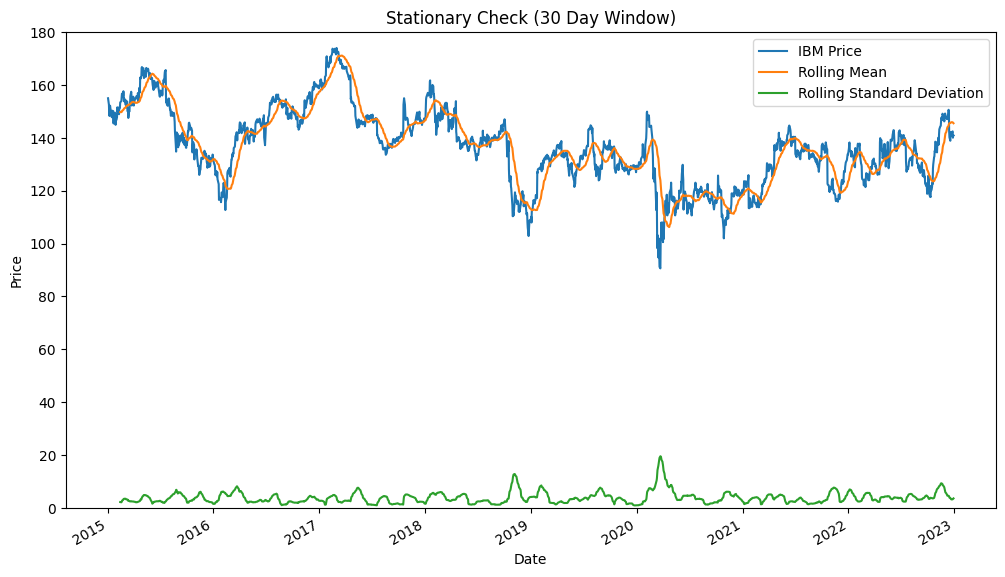

In [19]:
plot_stocks(stationary_stocks, df)

In [20]:
! pip install backtesting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173916 sha256=0c46c0e7b8dfca42a1f859b90cec4433a51b8623a9878112f707c201f8edd1bd
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


In [21]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

In [26]:
# class MeanReversion(Strategy):
#     def init(self):
#         self.offset: float = 0.01
#         self.prices: pd.Series = data
#         self.ma: pd.Series = self.prices.rolling(window=30).mean()

#     def next(self):
#         size: float = 0.1
#         if self.prices < self.ma[-1] * (1 - self.offset):
#             if self.position.size < 0:
#                 self.buy()
#             self.buy(size=size)

#         elif self.data > self.ma[-1] * (1 + self.offset):
#             if self.position.size > 0:
#                 self.sell()
#             self.sell(size=size)

class MeanReversion(Strategy):
    n1 = 30  # Period for the moving average

    def init(self):
        # Compute moving average
        self.offset = 0.01  # Buy/sell when price is 1% below/above the moving average
        prices = self.data['Close']
        self.ma = self.I(self.compute_rolling_mean, prices, self.n1)

    def compute_rolling_mean(self, prices, window):
        return [(sum(prices[max(0, i - window):i]) / min(i, window)) if i > 0 else np.nan for i in range(len(prices))]

    def next(self):
        size = 0.1
        # If price drops to more than offset% below n1-day moving average, buy
        if self.data['Close'] < self.ma[-1] * (1 - self.offset):
            if self.position.size < 0:  # Check for existing short position
                self.buy()  # Close short position
            self.buy(size=size)

        # If price rises to more than offset% above n1-day moving average, sell
        elif self.data['Close'] > self.ma[-1] * (1 + self.offset):
            if self.position.size > 0:  # Check for existing long position
                self.sell()  # Close long position
            self.sell(size=size)

In [32]:
dataframe = yf.download('IBM', start='2015-01-01', end='2023-01-1')

[*********************100%%**********************]  1 of 1 completed


In [33]:
bt = Backtest(dataframe, MeanReversion, cash=1000, commission=0.002)
stats = bt.run()

In [34]:
bt.plot()

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p1315', ...)

In [35]:
print(stats)

Start                     2015-01-02 00:00:00
End                       2022-12-30 00:00:00
Duration                   2919 days 00:00:00
Exposure Time [%]                   35.054618
Equity Final [$]                  1666.745774
Equity Peak [$]                   1733.471511
Return [%]                          66.674577
Buy & Hold Return [%]               -9.063962
Return (Ann.) [%]                    6.600983
Volatility (Ann.) [%]                8.074718
Sharpe Ratio                         0.817488
Sortino Ratio                        1.543104
Calmar Ratio                         0.681452
Max. Drawdown [%]                   -9.686646
Avg. Drawdown [%]                   -1.966084
Max. Drawdown Duration      226 days 00:00:00
Avg. Drawdown Duration       23 days 00:00:00
# Trades                                   64
Win Rate [%]                            81.25
Best Trade [%]                      22.693387
Worst Trade [%]                    -15.150552
Avg. Trade [%]                    